In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision import datasets
import matplotlib.pyplot as plt
import numpy as np
import os


cuda
Test accuracy on FashionMNIST: 11.36%
Epoch 1/5, Loss: 0.4200, Accuracy: 86.97%
Epoch 2/5, Loss: 0.2697, Accuracy: 90.09%
Epoch 3/5, Loss: 0.2267, Accuracy: 91.08%
Epoch 4/5, Loss: 0.1966, Accuracy: 91.37%
Epoch 5/5, Loss: 0.1709, Accuracy: 91.93%


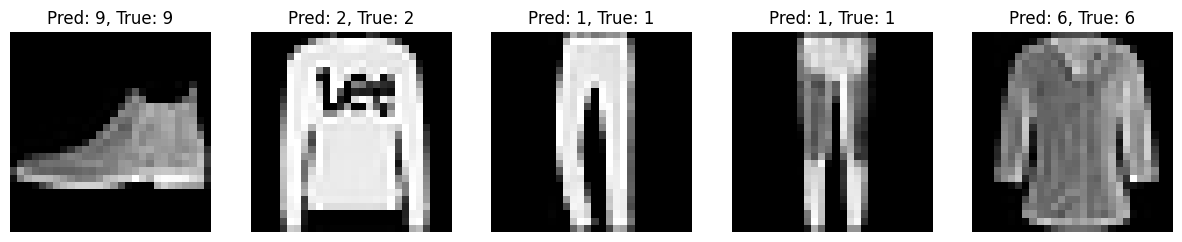

In [ ]:
#question1
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)) 
])

train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
print("cpu")

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(7*7*64, 128) 
        self.fc2 = nn.Linear(128, 10)      

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.max_pool2d(x, 2)
        x = torch.relu(self.conv2(x))
        x = torch.max_pool2d(x, 2)
        x = x.view(-1, 7*7*64)  
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = SimpleCNN()

def evaluate_model(model, test_loader):
    model.eval()  
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = correct / total
    return accuracy

accuracy = evaluate_model(model, test_loader)
print(f"Test accuracy on FashionMNIST: {accuracy * 100:.2f}%")

def fine_tune_model(model, train_loader, test_loader, epochs=5):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        accuracy = evaluate_model(model, test_loader)
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}, Accuracy: {accuracy * 100:.2f}%")

fine_tune_model(model, train_loader, test_loader, epochs=5)

def show_predictions(model, test_loader, num_images=5):
    model.eval()
    data_iter = iter(test_loader)
    inputs, labels = next(data_iter)
    outputs = model(inputs)
    _, predicted = torch.max(outputs, 1)

    _, axes = plt.subplots(1, num_images, figsize=(15, 15))
    for i in range(num_images):
        axes[i].imshow(inputs[i].squeeze(), cmap='gray')
        axes[i].set_title(f"Pred: {predicted[i].item()}, True: {labels[i].item()}")
        axes[i].axis('off')

    plt.show()

show_predictions(model, test_loader)


In [3]:
#question2
transform = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]),
}

data_dir = 'cats_and_dogs_filtered'
train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform['train'])
val_dataset = datasets.ImageFolder(os.path.join(data_dir, 'validation'), transform['val'])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

model = models.alexnet(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

model.classifier[6] = nn.Linear(model.classifier[6].in_features, 2)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

epochs = 5

def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=5):
    best_acc = 0.0
    for epoch in range(epochs):
        model.train()  
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        model.eval()  
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = correct / total
        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}, Accuracy: {accuracy*100:.2f}%")

        if accuracy > best_acc:
            best_acc = accuracy
            torch.save(model.state_dict(), 'best_model.pth')

train_model(model, train_loader, val_loader, criterion, optimizer, epochs)

model.eval()  
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f"Final Accuracy on the validation set: {accuracy*100:.2f}%")

def visualize_predictions(model, val_loader):
    model.eval()
    data_iter = iter(val_loader)
    inputs, labels = next(data_iter)
    outputs = model(inputs.to(device))
    _, predicted = torch.max(outputs, 1)

    fig, axes = plt.subplots(1, 5, figsize=(15, 15))
    for i in range(15):
        axes[i].imshow(inputs[i].permute(1, 2, 0).cpu().numpy())
        axes[i].set_title(f"Pred: {'Dog' if predicted[i] == 1 else 'Cat'}, True: {'Dog' if labels[i] == 1 else 'Cat'}")
        axes[i].axis('off')

    plt.show()
visualize_predictions(model, val_loader)


FileNotFoundError: [WinError 3] The system cannot find the path specified: 'cats_and_dogs_filtered\\train'

In [15]:
#question3
def save_checkpoint(state, filename="checkpoint.pth.tar"):
    """Saves the checkpoint to a file."""
    torch.save(state, filename)
    print(f"Checkpoint saved to {filename}")


def train_model_with_checkpoint(model, train_loader, val_loader, criterion, optimizer, num_epochs=5, checkpoint_interval=1):
    best_acc = 0.0 
    for epoch in range(num_epochs):
        model.train()  
        running_loss = 0.0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        model.eval()  
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = correct / total
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}, Accuracy: {accuracy*100:.2f}%")

        if accuracy > best_acc:
            best_acc = accuracy
            print(f"New best accuracy: {accuracy*100:.2f}%")
            save_checkpoint({
                'epoch': epoch + 1,
                'state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': running_loss / len(train_loader),
                'best_acc': best_acc
            }, filename="best_model.pth.tar")
        
        if (epoch + 1) % checkpoint_interval == 0:
            save_checkpoint({
                'epoch': epoch + 1,
                'state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': running_loss / len(train_loader),
                'best_acc': best_acc
            }, filename=f"checkpoint_epoch_{epoch + 1}.pth.tar")


data_dir = 'cats_and_dogs_filtered'

transform = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]),
}

train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform['train'])
val_dataset = datasets.ImageFolder(os.path.join(data_dir, 'validation'), transform['val'])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

model = models.alexnet(pretrained=True)
for param in model.parameters():
    param.requires_grad = False
model.classifier[6] = nn.Linear(model.classifier[6].in_features, 2)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

train_model_with_checkpoint(model, train_loader, val_loader, criterion, optimizer, num_epochs=5, checkpoint_interval=1)



Epoch 1/5, Loss: 0.2740, Accuracy: 95.50%
New best accuracy: 95.50%
Checkpoint saved to best_model.pth.tar
Checkpoint saved to checkpoint_epoch_1.pth.tar
Epoch 2/5, Loss: 0.2117, Accuracy: 95.20%
Checkpoint saved to checkpoint_epoch_2.pth.tar
Epoch 3/5, Loss: 0.1964, Accuracy: 95.90%
New best accuracy: 95.90%
Checkpoint saved to best_model.pth.tar
Checkpoint saved to checkpoint_epoch_3.pth.tar
Epoch 4/5, Loss: 0.1957, Accuracy: 95.80%
Checkpoint saved to checkpoint_epoch_4.pth.tar
Epoch 5/5, Loss: 0.1857, Accuracy: 95.00%
Checkpoint saved to checkpoint_epoch_5.pth.tar
